# Calculation of inertia parameters from period measurements

To implement the bicycle Whipple model, we need 3 inertia parameters : $Ixx$, $Ixz$ et $Izz$. this code was built to determine these parameters from 3 values measured in the frame plane : $\overrightarrow{X},\overrightarrow{Z}$, along 3 non parallel axes : 

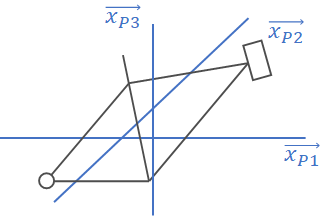

An example of one axis of oscillation for the frame of a cargo bicycle is the following : 
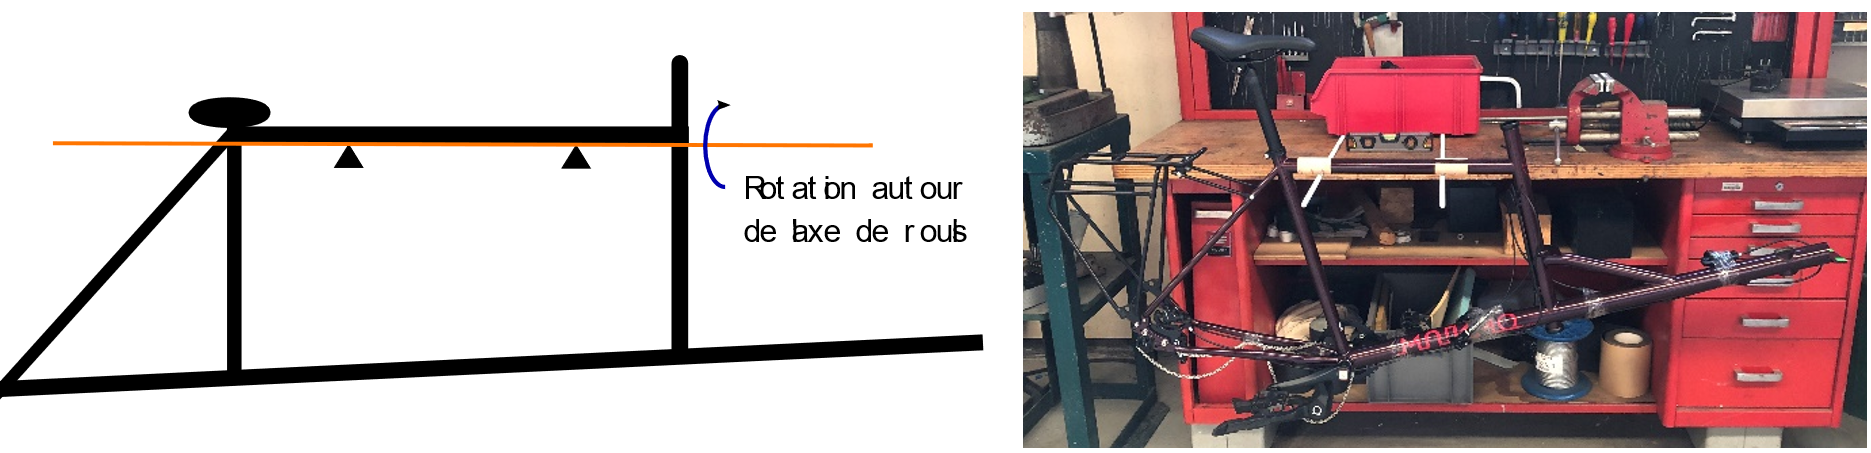

### Code description
This code needs csv files from IMU as entries. The code will get the oscillation's period from each signal, and then give the inertia of the part along this oscillation axis. Then, we will use linear tranformation to compute the 3 inertia parameters we want to measure, using the following system of equations.
$$J_{\beta i} = c_{\beta i}^2 I_{Bxx} - 2 c_{\beta i} s_{\beta i} I_{Bxz} + s_{\beta i}^2 I_{Bzz}$$

$J_{\beta i}$ are the inertia measured and $I_{Bxx}, I_{Bxz}, I_{Bzz}$ are the parameters we want to measure. $\beta i$ the angles of oscillation axis in the world reference frame (represented below) : 

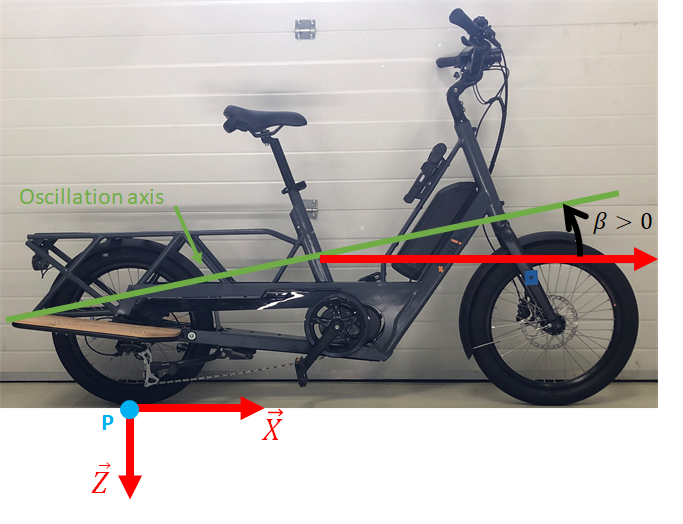

For each axis, we need the following :
- The distance between the oscillation axis and the part's center of gravity (measured with $2\_Tutorial\_distance\_measurement\_for\_inertia.ipynb$)
- The angle $\beta_i$ between the oscillation axis and the horizontal axis
- The mass of the part

### Libraries

In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from filters import * # Functions we developped for filtering
from math import *
from scipy.optimize import curve_fit

### Functions definition

In [2]:
def damping_function(t, A,B,ksi,omega,b):
    """
    
    Damping expression on which parameters will be optimized for recognizing the period of oscillations
    
    """
    return A+B*np.exp(-ksi*omega*t) * np.cos(sqrt(1-ksi**2)*omega*t + b)

def identify_period_and_damping(t,signal):
    """
    Identify the period and the damping coefficient of the signal
    
    Args:
        signal (np.ndarray): Temporal signal.
    
    Returns:
        tuple: Tuple with the period and damping coefficient
    """
    # Calcul de la transformée de Fourier du signal
    fft = np.fft.fft(signal)
    freqs = np.fft.fftfreq(len(signal))
    
    # Extraction des fréquences les plus importantes
    freqs = freqs[1:len(signal)//2]
    fft = np.abs(fft[1:len(signal)//2])
    
    # Identification de la fréquence dominante
    dominant_freq = freqs[np.argmax(fft)]
    
    # Calcul de la période
    period = 1 / dominant_freq
    
    
    # Calcul des paramètres d'amortissement à partir de la fonction d'amortissement
    ((A,B,ksi,omega,b),_) = curve_fit(damping_function, t, signal,bounds=([0,-10,0,2*3.14/3,-2*3.14],[4,10,1,2*3.14/0.5,2*3.14]))
    
    return A,B,ksi,omega,b

def extract_period(k,t_i,axe,draw):
    """
    
    Compute the mean period of the input signal
    
    """
    fs=120
    fc=2
    T_fused=[]
    


    data=np.loadtxt(f"{list_name_csv[k]}", delimiter = ',', skiprows = 2, usecols=range(11)).T

    ind_t_i=int(t_i*fs)
    gyr_x,gyr_y,gyr_z=data[-3:,:]
    
    
    t_f=data[-3:,:].shape[1]/fs
    t=np.linspace(0,t_f,gyr_x.shape[0])
    
    ax=axe[k]
    if ax=='x':
        gyr=gyr_x
    if ax=='y':
        gyr=gyr_y
    if ax=='z':
        gyr=gyr_z
    

    cut_gyr=gyr[ind_t_i:]
    t_cut=np.linspace(0,t_f-t_i,cut_gyr.shape[0])

    
    cut_gyr=butter_lowpass_filter(cut_gyr, fc , fs, order=5)
    
    peaks, _ = find_peaks(cut_gyr, height=0,distance=60)

    #Les deux premiers points sont retirés car généralement mauvais
    T=np.diff(t[peaks])[2:]
    print(T)
    T_mean=np.mean(T)
    B_max=np.max(np.abs(cut_gyr[peaks]))
    phi=2*3.14*t_cut[peaks][0]/T_mean
    
    A_mean=np.mean(cut_gyr)
    
    bounds=([A_mean*0.99,B_max*1,0.001,0.9*2*3.14/T_mean,-phi],[abs(A_mean*1.01),B_max*1.2,0.05,1.1*2*3.14/T_mean,phi])


    p0=[0,B_max*0.9,0.01,2*3.14/T_mean,phi]

    (A,B,ksi,omega,b),_= curve_fit(damping_function, t_cut, cut_gyr,bounds=bounds)
    T_opti=2*3.14/omega
    
    print('File',f"{list_name_csv[k]}",':')
    
    print('ksi=',ksi)
    print('Omega=',omega,'rad/s')
    
    T_fused.append(2*3.14/omega)
    
    if draw==1:
        plt.figure()
        gyr_fitted=damping_function(t_cut,A,B,ksi,omega,b)
        plt.plot(t_cut,gyr_fitted,label='Optimized')
        plt.plot(t_cut[peaks], cut_gyr[peaks], "x",label='Peaks')
        plt.plot(t_cut,cut_gyr,label='measure')
        plt.xlabel('Time (s)')
        plt.ylabel('Speed (°/s)')
        plt.legend()

    if draw==2:
        
        plt.figure()
        
        plt.hist(T_fused)
                
    return(T_fused)

def I(m,L,T):
    # Calcul l'inertie au centre de gravité de la pièce à partir 
    # de la période d'oscillation, de la masse et de la distance
    # au centre de gravité
    return(m*9.81*L/(2*3.14/T)**2-m*L**2)

#Méthode analytique 

def dI_dm(L,T):
    # Calcul l'incertitude sur l'inertie liée à la masse
    return(9.81*L*T**2/(4*3.14**2)-L**2)

def dI_dT(m,L,T):
    # Calcul l'incertitude sur l'inertie liée à la période
    return(2*T*m*9.81*L/(4*3.14**2))

def dI_dL(m,L,T):
    # Calcul l'incertitude sur l'inertie liée à la distance
    return(m*9.81*T**2/(4*3.14**2)-m*2*L)

Folder where are stored the csv files

In [3]:
list_name_csv = glob.glob('addbike\\jeu_3\\*.csv')

### Definition of the code variables

# <font color='red'>These variables are the ones you need to modify according to your part</font>

In [4]:
# Select the index of the files for the measure
# (if you only have 3 files, you have nothing to change)
select=[0,1,2] 

# Mass of the part
masses=24.21
# Distances between axis of oscillation and part's center of gravity
distances=[0.210,0.4078,0.379] # m

# Angles of oscillation axis in the world reference frame
angles=[2.46,-18.8,63.2] # °

# Uncertainties estimated for the uncertainty evaluation
u_m=0.02 # mass
u_L=0.0203 # distance
u_T=0.02 # period

For each signal, take care of chosing the right axis to recognize the signal. 

In [5]:
axes=['y','y','y']

Next block will help chosing the right axis for having the maximum signal to noise ratio

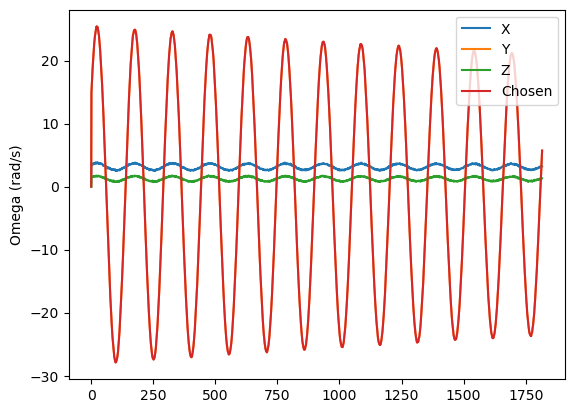

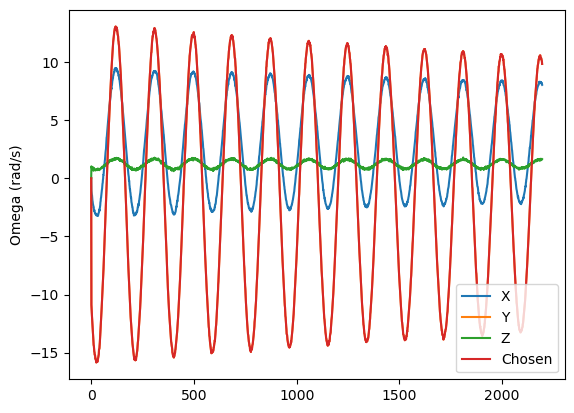

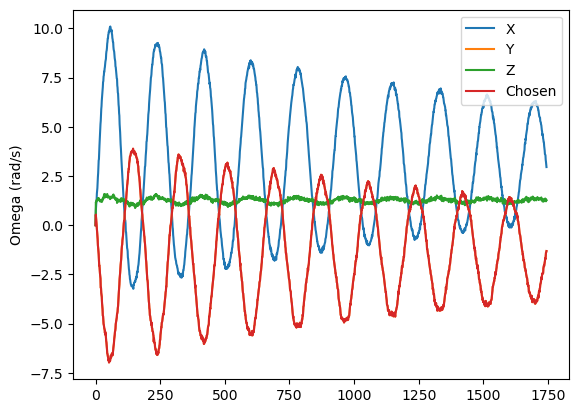

In [6]:
for k in range(len(axes)):
    data=np.loadtxt(f"{list_name_csv[k]}", delimiter = ',', skiprows = 2, usecols=range(11)).T
    gyr_x,gyr_y,gyr_z=data[-3:,:]
    ax=axes[k]
    if ax=='x':
        gyr=gyr_x
    if ax=='y':
        gyr=gyr_y
    if ax=='z':
        gyr=gyr_z
    plt.figure()
    plt.plot(gyr_x,label = 'X')
    plt.plot(gyr_y,label = 'Y')
    plt.plot(gyr_z,label = 'Z')
    plt.plot(gyr,label='Chosen')
    plt.legend()
    plt.ylabel('Omega (rad/s)')

To make sure that we have correct measurements, we crop the signal to keep only the good part of the signal. 

In [7]:
times=[1,7,3]

### Inertia calculation around each oscillation axis

Using the second law of Newton, we can write the following equation : 
$$J_{\beta_i} = \frac{m g L} {\omega^2} - m L^2$$
With the measured inertia $J_{\beta_i}$, $m$ the mass, $L$ the distance between the oscillation axis and the center of gravity, and $g$ the gravity constant. 

[1.26736417 1.26736417 1.26736417 1.26736417 1.26736417 1.26736417
 1.26736417 1.26736417]
File addbike\jeu_3\addbike_D422CD0051A7_20230927_153433.csv :
ksi= 0.002142872123137357
Omega= 4.957977816051188 rad/s
Inertia measured around oscillation axis:
Angle of 2.46 °
Inertia : I= 0.961 kg.m² +/- 0.0649
-----------------------------------------
[1.56738074 1.56738074 1.5590436  1.56738074]
File addbike\jeu_3\addbike_D422CD0051A7_20230927_160207.csv :
ksi= 0.0019684353028391775
Omega= 4.013610543521172 rad/s
Inertia measured around oscillation axis:
Angle of -18.8 °
Inertia : I= 1.986 kg.m² +/- 0.1842
-----------------------------------------
[1.52587443 1.51753631 1.52587443 1.52587443 1.52587443]
File addbike\jeu_3\addbike_D422CD0051A7_20230927_165807.csv :
ksi= 0.004621792123344984
Omega= 4.121596386250844 rad/s
Inertia measured around oscillation axis:
Angle of 63.2 °
Inertia : I= 1.821 kg.m² +/- 0.165
-----------------------------------------


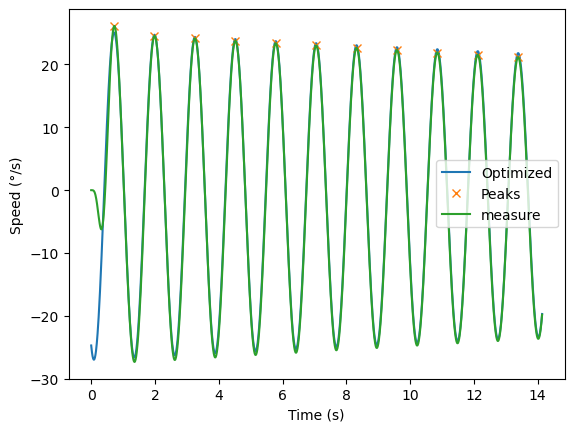

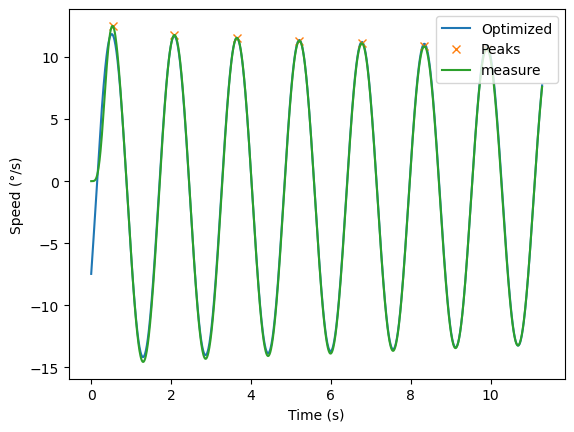

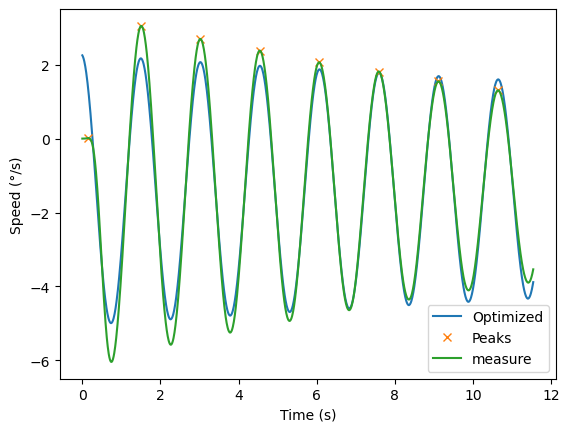

In [8]:
Inertia=[]
u_Inertia=[]

for k in range(len(select)):

    m_moy=masses
    L_moy=distances[k]
    angle=angles[k]
    
    T_mean=extract_period(k,times[k],axes,1)[0]
    
    I_1=I(m_moy,L_moy,T_mean)
    
    I_mean=I_1

    u_I=np.sqrt(dI_dm(L_moy,T_mean)**2*u_m**2+dI_dT(m_moy,L_moy,T_mean)**2*u_T**2+dI_dL(m_moy,L_moy,T_mean)**2*u_L**2)
    
    def u_I_rel(L_moy):
        U_I_rel=np.sqrt((u_m/m_moy)**2+((2*(I_mean+L_moy**2*m_moy)/I_mean)*(u_T/T_mean))**2+(((I_mean-m_moy*L_moy**2)/T_mean)*(u_L/L_moy))**2)
        return(U_I_rel)
    
    Inertia.append(I_mean)
    u_Inertia.append(u_I)
    
    print("Inertia measured around oscillation axis:")
    print(f'Angle of {angle} °')
    print('Inertia :','I=',round(I_mean,3),'kg.m²',"+/-",round(u_I,4))
    print('-----------------------------------------')

### Identification of the right parameters

Now we will use the following expressions to identify our 3 Whipple parameters $I_{Bxx}, I_{Bxz}, I_{Bzz}$ :
$$J_{\beta i} = c_{\beta i}^2 I_{Bxx} - 2 c_{\beta i} s_{\beta i} I_{Bxz} + s_{\beta i}^2 I_{Bzz}$$

To minimize the uncertainties linked to our measurment and calculations, we need to be sure that the oscillation axis chosen are not aligned with the world reference frame axes. More specifically, if the oscillation axes are to close to 0 or 90°, singularities will appear while computing the linear decoupling. If one of your axis is close to 0 or 90°, you can use the function at the end of this notebook to compute the linear system using only 2 unknown variables. 

In [9]:
from scipy import linalg

def solve_coupled_inertia(angles,Inertia):

    A=np.array([[cos(np.deg2rad(angles[k]))**2,-2*sin(np.deg2rad(angles[k]))*cos(np.deg2rad(angles[k])),sin(np.deg2rad(angles[k]))**2] for k in range(len(select))])
    B=np.array(Inertia)

    I11,I12,I22 = linalg.solve(A, B)
    return(I11,I12,I22)

I11,I12,I22=solve_coupled_inertia(angles,Inertia)
u_angles=[1,1,1] # uncertainty of the angle measurement

N=5000

I_rand_1 = np.random.normal(Inertia[0], u_Inertia[0], N)
I_rand_2 = np.random.normal(Inertia[1], u_Inertia[1], N)
I_rand_3 = np.random.normal(Inertia[2], u_Inertia[2], N)
angle_rand_1 =  np.random.normal(angles[0], u_angles[0], N)
angle_rand_2 =  np.random.normal(angles[1], u_angles[1], N)
angle_rand_3 =  np.random.normal(angles[2], u_angles[2], N)

Inertia_rand=np.array([I_rand_1,I_rand_2,I_rand_3])
angle_rand=np.array([angle_rand_1,angle_rand_2,angle_rand_3])

list_I_rand=np.empty((N,3))

for n in range(N):
    Inertia=Inertia_rand[:,n]
    angles=angle_rand[:,n]
    list_I_rand[n]=solve_coupled_inertia(angles,Inertia)
    
I11_std,I12_std,I22_std=np.std(list_I_rand,axis=0)



print("Uncertainties evaluated by an analytical method:")

print('Inertie :','I_11=',round(I11,3),'kg.m²',"+/-",round(I11_std,4))
print('Inertie :','I_12=',round(I12,3),'kg.m²',"+/-",round(I12_std,4))
print('Inertie :','I_22=',round(I22,3),'kg.m²',"+/-",round(I22_std,4))
print('-----------------------------------------')

Uncertainties evaluated by an analytical method:
Inertie : I_11= 1.057 kg.m² +/- 0.0714
Inertie : I_12= 1.16 kg.m² +/- 0.2579
Inertie : I_22= 3.188 kg.m² +/- 0.3221
-----------------------------------------


### Code available to use the same method but with one inertia directly measured
If one of your angle is 0 or 90°, you can use this function insted of the previous one. By doing this, you will avoid some numerical singularities. 

In [10]:
"""
from scipy import linalg

def solve_coupled_inertia_2dimensions(angles,Inertia):
    A=np.array([[-2*sin(np.deg2rad(angles[k]))*cos(np.deg2rad(angles[k])),sin(np.deg2rad(angles[k]))**2] for k in range(len(Inertia))])
    B=np.array(Inertia)
    B[0] = B[0] - cos(np.deg2rad(angles[0]))**2*I11
    B[1] = B[1] - cos(np.deg2rad(angles[1]))**2*I11

    I12,I22 = linalg.solve(A, B)
    return(I12,I22)

select=[1,2]
I11 = Inertia[0]
u_I11 = u_Inertia[0]
I12,I22=solve_coupled_inertia_2dimensions(angles[1:],Inertia[1:])
u_angles=[1,1,1] # uncertainty of the angle measurement

N=5000

I_rand_1 = np.random.normal(Inertia[0], u_Inertia[0], N)
I_rand_2 = np.random.normal(Inertia[1], u_Inertia[1], N)
I_rand_3 = np.random.normal(Inertia[2], u_Inertia[2], N)
angle_rand_1 = np.random.normal(angles[0], u_angles[0], N)
angle_rand_2 =  np.random.normal(angles[1], u_angles[1], N)
angle_rand_3 =  np.random.normal(angles[2], u_angles[2], N)

Inertia_rand=np.array([I_rand_1,I_rand_2,I_rand_3])
angle_rand=np.array([angle_rand_1,angle_rand_2,angle_rand_3])

list_I_rand=np.empty((N,2))

for n in range(N):
    Inertia=Inertia_rand[1:,n]
    angles=angle_rand[1:,n]
    list_I_rand[n]=solve_coupled_inertia_2dimensions(angles,Inertia)
    
I12_std,I22_std=np.std(list_I_rand,axis=0)
I11_std = u_Inertia[0]


print("Méthode numérique :")

print('Inertie :','I_11=',round(I11,3),'kg.m²',"+/-",round(I11_std,4))
print('Inertie :','I_12=',round(I12,3),'kg.m²',"+/-",round(I12_std,4))
print('Inertie :','I_22=',round(I22,3),'kg.m²',"+/-",round(I22_std,4))
print('-----------------------------------------')
"""

'\nfrom scipy import linalg\n\ndef solve_coupled_inertia_2dimensions(angles,Inertia):\n    A=np.array([[-2*sin(np.deg2rad(angles[k]))*cos(np.deg2rad(angles[k])),sin(np.deg2rad(angles[k]))**2] for k in range(len(Inertia))])\n    B=np.array(Inertia)\n    B[0] = B[0] - cos(np.deg2rad(angles[0]))**2*I11\n    B[1] = B[1] - cos(np.deg2rad(angles[1]))**2*I11\n\n    I12,I22 = linalg.solve(A, B)\n    return(I12,I22)\n\nselect=[1,2]\nI11 = Inertia[0]\nu_I11 = u_Inertia[0]\nI12,I22=solve_coupled_inertia_2dimensions(angles[1:],Inertia[1:])\nu_angles=[1,1,1] # uncertainty of the angle measurement\n\nN=5000\n\nI_rand_1 = np.random.normal(Inertia[0], u_Inertia[0], N)\nI_rand_2 = np.random.normal(Inertia[1], u_Inertia[1], N)\nI_rand_3 = np.random.normal(Inertia[2], u_Inertia[2], N)\nangle_rand_1 = np.random.normal(angles[0], u_angles[0], N)\nangle_rand_2 =  np.random.normal(angles[1], u_angles[1], N)\nangle_rand_3 =  np.random.normal(angles[2], u_angles[2], N)\n\nInertia_rand=np.array([I_rand_1,I_rand